# TensorFlow的手写体数字识别

本模型主要采用LeNet-5网络结构，构建了能够识别手写体数字的模型，并且采取了若干比较先进的技巧提升模型的能力，防止过拟合，提升模型效果。

此外本模型还使用了TensorBoard可视化模型结构和模型变量。

## LeNet网络结构
![LeNet网络结构](https://img-blog.csdn.net/20150903161702138?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQv/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/Center)

## 导入相关包

In [1]:
import gzip
import os
from six.moves import urllib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## 超参数定义

In [2]:
SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'
WORK_DIRECTORY = 'Mnist'
IMAGE_SIZE = 28
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
NUM_LABELS = 10
VALIDATION_SIZE = 5000  # Size of the validation set.
SEED = 66478  # Set to None for random seed.
BATCH_SIZE = 200
NUM_EPOCHS = 20
EVAL_BATCH_SIZE = 100
EVAL_FREQUENCY = 100  # Number of steps between evaluations.

## 数据处理（不要求掌握）

In [3]:
def maybe_download(filename):
    """Download the data from Yann's website, unless it's already here."""
    if not tf.gfile.Exists(WORK_DIRECTORY):
        tf.gfile.MakeDirs(WORK_DIRECTORY)
    filepath = os.path.join(WORK_DIRECTORY, filename)
    if not tf.gfile.Exists(filepath):
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
    with tf.gfile.GFile(filepath) as f:
        size = f.size()
    print('Successfully downloaded', filename, size, 'bytes.')
    return filepath

In [4]:
def extract_data(filename, num_images):
    """Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
        data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
    return data

In [5]:
def extract_labels(filename, num_images):
    """Extract the labels into a vector of int64 label IDs."""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

## 计算准确率

In [6]:
def error_rate(predictions, labels):
    """Return the error rate based on dense predictions and sparse labels."""
    return 100.0 - (
      100.0 *
      np.sum(np.argmax(predictions, 1) == labels) /
      predictions.shape[0])

In [7]:
train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')

# Extract it into numpy arrays.
train_data = extract_data(train_data_filename, 60000)
train_labels = extract_labels(train_labels_filename, 60000)
test_data = extract_data(test_data_filename, 10000)
test_labels = extract_labels(test_labels_filename, 10000)

# Generate a validation set.
validation_data = train_data[:VALIDATION_SIZE, ...]
validation_labels = train_labels[:VALIDATION_SIZE]
train_data = train_data[VALIDATION_SIZE:, ...]
train_labels = train_labels[VALIDATION_SIZE:]
num_epochs = NUM_EPOCHS
train_size = train_labels.shape[0]

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting Mnist/train-images-idx3-ubyte.gz
Extracting Mnist/train-labels-idx1-ubyte.gz
Extracting Mnist/t10k-images-idx3-ubyte.gz
Extracting Mnist/t10k-labels-idx1-ubyte.gz


## 参数定义

namescope帮助分类，能够合理的可视化结果。

summary记录参数信息帮助tensorboard可视化。

histogram表示分布直方图。

卷积层可以使用封装更好的`layer`结构，但是这里为了帮助大家理解卷积的含义，详细写出卷基层的参数。
```python
out = tf.contrib.layers.conv2d(inputs,
    num_outputs,
    kernel_size,
    stride=1,
    padding='SAME',
    data_format=None,
    rate=1,
    activation_fn=tf.nn.relu,
    normalizer_fn=None,
    normalizer_params=None,
    weights_initializer=initializers.xavier_initializer(),
    weights_regularizer=None,
    biases_initializer=tf.zeros_initializer(),
    biases_regularizer=None,
    reuse=None,
    variables_collections=None,
    outputs_collections=None,
    trainable=True,
    scope=None)
```

In [8]:
with tf.name_scope('inputs'):
    train_data_node = tf.placeholder(
          dtype = tf.float32,
          shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
    train_labels_node = tf.placeholder(tf.int64, shape=(BATCH_SIZE,))
    eval_data = tf.placeholder(
          dtype = tf.float32,
          shape=(EVAL_BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))

28x28x1 -> 5x5x1x32 -> 28x28x32

28x28x32 -> 5x5x32x64 -> 28x28x64

In [9]:
with tf.name_scope('weights'):
    with tf.name_scope('conv_weights'):
        conv1_weights = tf.Variable(
              tf.truncated_normal([5, 5, NUM_CHANNELS, 32],  # 5x5 filter, depth 32.
                                  stddev=0.1,
                                  seed=SEED, dtype=tf.float32), name='conv1_w')
        conv1_biases = tf.Variable(tf.zeros([32], dtype=tf.float32), name='conv1_b')
        conv2_weights = tf.Variable(tf.truncated_normal(
              [5, 5, 32, 64], stddev=0.1,
              seed=SEED, dtype=tf.float32), name='conv2_w')
        conv2_biases = tf.Variable(tf.constant(0.1, shape=[64], dtype=tf.float32), name='conv2_b')
        tf.summary.histogram('conv1_w', conv1_weights)
        tf.summary.histogram('conv1_b', conv1_biases)
        tf.summary.histogram('conv2_w', conv2_weights)
        tf.summary.histogram('conv2_b', conv2_biases)
    with tf.name_scope('fc_weights'):
        fc1_weights = tf.Variable(  # fully connected, depth 512.
              tf.truncated_normal([IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * 64, 512],
                                  stddev=0.1,
                                  seed=SEED,
                                  dtype=tf.float32), name='fc1_w')
        fc1_biases = tf.Variable(tf.constant(0.1, shape=[512], dtype=tf.float32), name='fc1_b')
        fc2_weights = tf.Variable(tf.truncated_normal([512, NUM_LABELS],
                                                        stddev=0.1,
                                                        seed=SEED,
                                                        dtype=tf.float32, name='fc2_w'))
        fc2_biases = tf.Variable(tf.constant(0.1, shape=[NUM_LABELS], dtype=tf.float32), name='fc2_b')
        tf.summary.histogram('fc1_w', fc1_weights)
        tf.summary.histogram('fc1_b', fc1_biases)
        tf.summary.histogram('fc2_w', fc2_weights)
        tf.summary.histogram('fc2_b', fc2_biases)

## 模型定义
按照LeNet结构完成模型。

激活函数使用ReLU，并在全连接部分增加了Dropout防止过拟合。

In [10]:
def model(data, train=False):
    """The Model definition."""
    # 2D convolution, with 'SAME' padding (i.e. the output feature map has
    # the same size as the input). Note that {strides} is a 4D array whose
    # shape matches the data layout: [image index, y, x, depth].
    with tf.name_scope('operations'):
        with tf.name_scope('convs_pool'):
            conv = tf.nn.conv2d(data,
                                conv1_weights,
                                strides=[1, 1, 1, 1],
                                padding='SAME')
            # Bias and rectified linear non-linearity.
            relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
            # Max pooling. The kernel size spec {ksize} also follows the layout of
            # the data. Here we have a pooling window of 2, and a stride of 2.
            pool = tf.nn.max_pool(relu,
                                  ksize=[1, 2, 2, 1],
                                  strides=[1, 2, 2, 1],
                                  padding='SAME')
            conv = tf.nn.conv2d(pool,
                                conv2_weights,
                                strides=[1, 1, 1, 1],
                                padding='SAME')
            relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
            pool = tf.nn.max_pool(relu,
                                  ksize=[1, 2, 2, 1],
                                  strides=[1, 2, 2, 1],
                                  padding='SAME')
            # Reshape the feature map cuboid into a 2D matrix to feed it to the
            # fully connected layers.
            pool_shape = pool.get_shape().as_list()
            reshape = tf.reshape(
                pool,
                [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
        # Fully connected layer. Note that the '+' operation automatically
        # broadcasts the biases.
        with tf.name_scope('fc'):
            hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
            # Add a 50% dropout during training only. Dropout also scales
            # activations such that no rescaling is needed at evaluation time.
            if train:
                hidden = tf.nn.dropout(hidden, 0.5, seed=SEED)
            out = tf.matmul(hidden, fc2_weights) + fc2_biases
    return out

## 损失函数以及训练
损失函数除了cross entropy还使用了参数正则化，防止参数$L_2 Norm$过大而过拟合。

同时使用学习率衰减策略，更快收敛，更好的拟合结果。

scalar是折线图。

In [11]:
logits = model(train_data_node, True)
with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
          labels=train_labels_node, logits=logits))
    tf.summary.scalar("cross_entropy", loss)
    # L2 regularization for the fully connected parameters.
    regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                    tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
    # Add the regularization term to the loss.
    loss += 5e-4 * regularizers
    tf.summary.scalar('regulizers', regularizers)
    tf.summary.scalar('total_loss', loss)
# Decay once per epoch, using an exponential schedule starting at 0.01.
with tf.name_scope('train'):
    batch = tf.Variable(0, dtype=tf.float32, trainable=False)
    learning_rate = tf.train.exponential_decay(
            0.01,                # Base learning rate.
            batch * BATCH_SIZE,  # Current index into the dataset.
            train_size,               # Decay step.
            0.95,                # Decay rate.
            staircase=True)
    tf.summary.scalar('learning_rate', learning_rate)
    # Use simple momentum for the optimization.
    optimizer = tf.train.MomentumOptimizer(learning_rate,
                                               0.9).minimize(loss,
                                                         global_step=batch)
# Predictions for the current training minibatch.
train_prediction = tf.nn.softmax(logits)

# Predictions for the test and validation, which we'll compute less often.
eval_prediction = tf.nn.softmax(model(eval_data))
saver = tf.train.Saver()

## 评估函数

In [12]:
# Small utility function to evaluate a dataset by feeding batches of data to
# {eval_data} and pulling the results from {eval_predictions}.
# Saves memory and enables this to run on smaller GPUs.
def eval_in_batches(data, sess):
    """Get all predictions for a dataset by running it in small batches."""
    size = data.shape[0]
    if size < EVAL_BATCH_SIZE:
        raise ValueError("batch size for evals larger than dataset: %d" % size)
    predictions = np.ndarray(shape=(size, NUM_LABELS), dtype=np.float32)
    for begin in range(0, size, EVAL_BATCH_SIZE):
        end = begin + EVAL_BATCH_SIZE
        if end <= size:
            predictions[begin:end, :] = sess.run(
                eval_prediction,
                feed_dict={eval_data: data[begin:end, ...]})
        else:
            batch_predictions = sess.run(
                eval_prediction,
                feed_dict={eval_data: data[-EVAL_BATCH_SIZE:, ...]})
            predictions[begin:, :] = batch_predictions[begin - size:, :]
    return predictions

## 模型训练
Saver用来保存模型参数。

通过各种训练技巧在不对数据集做argmentation的情况下达到了超过LeNet5论文report的水平。

In [13]:
config=tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
prediction = []
with tf.Session(config=config) as sess:
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter("./Mnist/logs/", sess.graph)
    # Run all the initializers to prepare the trainable parameters.
    tf.global_variables_initializer().run()
    ckpt = tf.train.get_checkpoint_state("Mnist/model/lenet.ckpt")
    if ckpt:
        saver.restore(sess, ckpt.model_checkpoint_path)
    print('Initialized!')
    # Loop through training steps.
    for step in range(int(num_epochs * train_size) // BATCH_SIZE):
#     for step in range(1):
        # Compute the offset of the current minibatch in the data.
        # Note that we could use better randomization across epochs.
        offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
        batch_data = train_data[offset:(offset + BATCH_SIZE), ...]
        batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
        # This dictionary maps the batch data (as a numpy array) to the
        # node in the graph it should be fed to.
        feed_dict = {train_data_node: batch_data,
                   train_labels_node: batch_labels}
        # Run the optimizer to update weights.
        _, rs = sess.run((optimizer, merged), feed_dict=feed_dict)
        writer.add_summary(rs, step)
        # print some extra information once reach the evaluation frequency
        if step % EVAL_FREQUENCY == 0:
            # fetch some extra nodes' data
            l, lr, predictions = sess.run([loss, learning_rate, train_prediction],
                                      feed_dict=feed_dict)
            print('Step %d (epoch %.2f)' %
              (step, float(step) * BATCH_SIZE / train_size))
            print('Minibatch loss: %.3f, learning rate: %.6f' % (l, lr))
            print('Minibatch error: %.1f%%' % error_rate(predictions, batch_labels))
            print('Validation error: %.1f%%' % error_rate(
                eval_in_batches(validation_data, sess), validation_labels))
            save_path = saver.save(sess, "Mnist/model/lenet.ckpt")
#             sys.stdout.flush()
        # Finally print the result!
        test_error = error_rate(eval_in_batches(test_data, sess), test_labels)
        print('Test error: %.1f%%' % test_error)
    prediction = eval_in_batches(test_data, sess)

Initialized!
Step 0 (epoch 0.00)
Minibatch loss: 8.489, learning rate: 0.010000
Minibatch error: 84.5%
Validation error: 81.9%
Test error: 82.2%
Test error: 78.0%
Test error: 72.6%
Test error: 74.3%
Test error: 73.2%
Test error: 63.9%
Test error: 66.6%
Test error: 59.3%
Test error: 52.8%
Test error: 51.0%
Test error: 54.1%
Test error: 61.2%
Test error: 60.0%
Test error: 47.4%
Test error: 38.7%
Test error: 35.8%
Test error: 35.5%
Test error: 34.5%
Test error: 32.7%
Test error: 30.5%
Test error: 28.6%
Test error: 26.5%
Test error: 25.5%
Test error: 23.9%
Test error: 21.3%
Test error: 18.9%
Test error: 17.4%
Test error: 16.6%
Test error: 16.2%
Test error: 16.6%
Test error: 16.8%
Test error: 15.9%
Test error: 15.1%
Test error: 14.4%
Test error: 14.1%
Test error: 14.3%
Test error: 14.5%
Test error: 14.2%
Test error: 13.3%
Test error: 12.8%
Test error: 12.2%
Test error: 11.7%
Test error: 11.2%
Test error: 10.7%
Test error: 10.5%
Test error: 10.0%
Test error: 9.7%
Test error: 9.4%
Test error:

## 分类结果的可视化

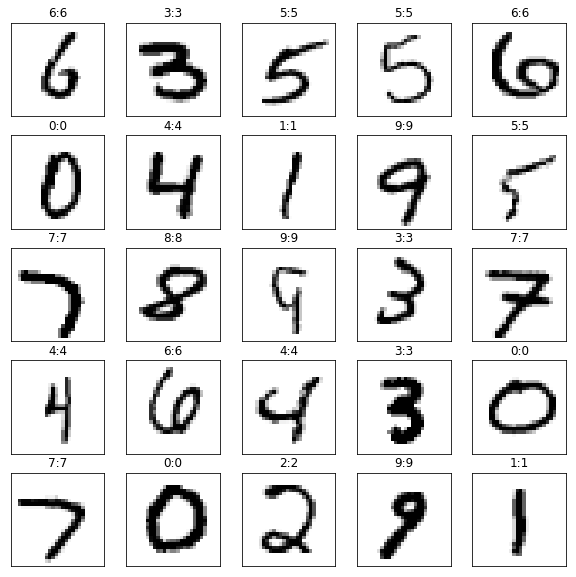

In [17]:
def image_grid():
    """Return a 5x5 grid of the MNIST images as a matplotlib figure."""
    # Create a figure to contain the plot.
    figure = plt.figure(figsize=(10,10))
    for i in range(25):
        # Start next subplot.
        plt.subplot(5, 5, i + 1, title=str(test_labels[i+50])+":"+str(np.argmax(prediction[i+50])))
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = np.array(255*(test_data[i+50]+0.5)).astype(int)
        plt.imshow(img.reshape(28,28), cmap=plt.cm.binary)

    return figure

# Prepare the plot
figure = image_grid()
# Convert to image and log